a)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
import pandas as pd
import os

In [21]:
def _sigmoid(x): 
    return 1 / (1 + np.exp(-x))

def _nll(theta, X, y):
    z = X @ theta
    return np.logaddexp(0.0, z).sum() - (y * z).sum()

def _grad(theta, X, y):
    p = _sigmoid(X @ theta)
    return X.T @ (p - y)


In [88]:
def fit_logreg_gd_backtracking_with_history(X, y, tol=1e-6):

    alpha = 0.1
    beta  = 0.1
    t0    = 1.0

    X = np.asarray(X, float)
    y = np.asarray(y, float)
    theta = np.zeros(X.shape[1], float)
    history = [theta.copy()]

    
    while True:
        g = _grad(theta, X, y)
        if np.linalg.norm(g) <= tol:
            break

        d = -g
        f0 = _nll(theta, X, y)
        t = t0

        # backtracking Armijo condition
        while _nll(theta + t*d, X, y) > f0 + alpha * t * (g @ d):
            t *= beta
            
        theta = theta + t * d
        history.append(theta.copy())

    return theta, history

b)

The result is [-24.56438049,   0.20093098,   0.19741933], which is really closed to what we got in “logistic-regression.pdf”. So we can say that code from part (a) can get close to the same solution.

In [90]:
data = pd.read_csv("../Downloads/marks.txt")
# X = feature values, all the columns except the last column
X = data.iloc[:, :-1]
X = np.c_[np.ones((X.shape[0], 1)), X] ## augment with column of ones
# y = target values, last column of the data frame
y = data.iloc[:, -1].to_numpy()


In [98]:
theta, history = fit_logreg_gd_backtracking_with_history(X, y, tol=1e-2)

In [99]:
theta

array([-24.56438049,   0.20093098,   0.19741933])

In [100]:
len(history)

2580583

c)

In [104]:
def plot_theta_trajectory_3d(theta_history):
    TH = np.vstack(theta_history)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(TH[:,0], TH[:,1], TH[:,2], marker='o')
    ax.scatter(TH[0,0], TH[0,1], TH[0,2], s=60, label='start')
    ax.scatter(TH[-1,0], TH[-1,1], TH[-1,2], s=60, label='end')
    ax.set_xlabel(r'$\theta_0$ (intercept)')
    ax.set_ylabel(r'$\theta_1$')
    ax.set_zlabel(r'$\theta_2$')
    ax.set_title('Newton trajectory in parameter space')
    ax.legend()
    plt.show()

def plot_loss_contours_with_path(X, y, theta_history, levels=20, margin=1.0, intercept='final'):
    TH = np.vstack(theta_history)
    if intercept == 'final':
        b = TH[-1,0]
    elif intercept == 'start':
        b = TH[0,0]
    else:
        b = float(intercept)

    t1_min, t1_max = TH[:,1].min()-margin, TH[:,1].max()+margin
    t2_min, t2_max = TH[:,2].min()-margin, TH[:,2].max()+margin

    t1 = np.linspace(t1_min, t1_max, 200)
    t2 = np.linspace(t2_min, t2_max, 200)
    T1, T2 = np.meshgrid(t1, t2)

    Z = np.empty_like(T1)
    for i in range(T1.shape[0]):
        thetas = np.c_[np.full(T1.shape[1], b), T1[i], T2[i]]
        Z[i] = np.array([_nll(th, X, y) for th in thetas])

    plt.figure()
    CS = plt.contour(T1, T2, Z, levels=levels)
    plt.clabel(CS, inline=True, fontsize=8)
    plt.plot(TH[:,1], TH[:,2], marker='o')
    plt.scatter(TH[0,1], TH[0,2], s=60)
    plt.scatter(TH[-1,1], TH[-1,2], s=60)
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.title(f'Loss contours at fixed intercept θ0={b:.3f} (Newton path)')
    plt.show()

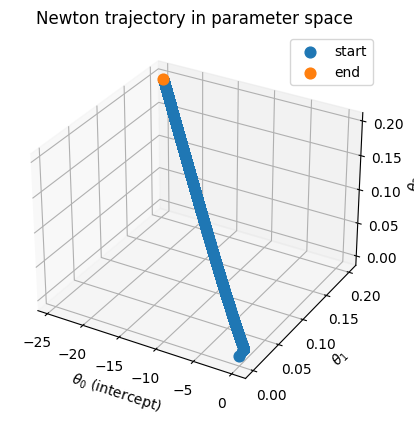

In [106]:
plot_theta_trajectory_3d(history)

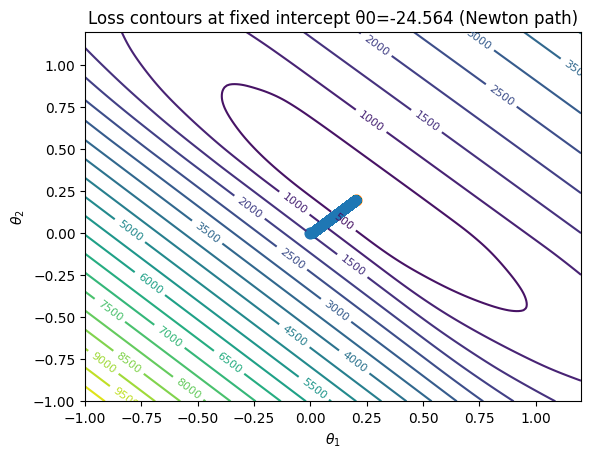

In [110]:
plot_loss_contours_with_path(X, y, history, levels=20, margin=1.0, intercept='final')

d)

Answer after running the code: It converges to the right solution. It takes less steps and spends less time in both cases: with and without backtracking campared to the code in part(a). In this part I choose a larger alpha = 0.8 to see the difference with backtracking. When alpha = 0.1, backtracking on makes no difference. Adding backtracking does not influence the converge. We can see the results of two cases are nearly the same. But backtracking in some cases helps us make the progress safe and increase the cost.

This code can toggle backtracking on and off. I ran the code twice, once without backtracking and once with it, to observe the difference.

In [287]:
def fit_logreg_newton_irls(X, y, tol=1e-2, backtracking=False):

    X = np.asarray(X, float)
    y = np.asarray(y, float).reshape(-1)
    theta = np.zeros(X.shape[1], float)
    history = [theta.copy()]

    # Backtracking parameters
    alpha = 0.8
    beta  = 0.1
    t0    = 1.0

    while True:
        # Linear predictor & predicted probabilities
        z_lin = X @ theta
        mu = _sigmoid(z_lin)

        # Gradient and Hessian
        g = X.T @ (mu - y)
        if np.linalg.norm(g) <= tol:
            break

        w = mu * (1.0 - mu)
        w = np.clip(w, 1e-12, None)
        Xw = X * w[:, None]
        H = X.T @ Xw

        # Newton direction: solve H d = -g
        d = np.linalg.solve(H, -g)

        # Choose step size
        if backtracking == True:
            f0 = _nll(theta, X, y)
            t = t0
            # Armijo condition
            while _nll(theta + t * d, X, y) > f0 + alpha * t * (g @ d):
                t *= beta
        else:
            t = 1.0   

        # Parameter update
        theta = theta + t * d
        history.append(theta.copy())

    return theta, history


In [289]:
theta, history = fit_logreg_newton_irls(X, y, tol=1e-2)

In [291]:
theta

array([-24.86993268,   0.20338195,   0.19988172])

In [293]:
history

[array([0., 0., 0.]),
 array([-7.13638166,  0.05832469,  0.05618019]),
 array([-12.3346134 ,   0.10139698,   0.0974893 ]),
 array([-17.85653092,   0.14659921,   0.14240198]),
 array([-22.50314087,   0.18428766,   0.18048829]),
 array([-24.58488456,   0.20108681,   0.19755064]),
 array([-24.86569405,   0.20334784,   0.19984715]),
 array([-24.86993268,   0.20338195,   0.19988172])]

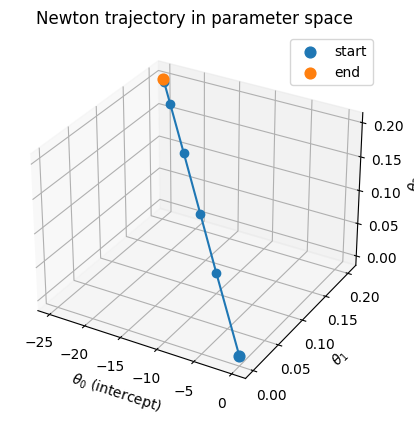

In [295]:
plot_theta_trajectory_3d(history)

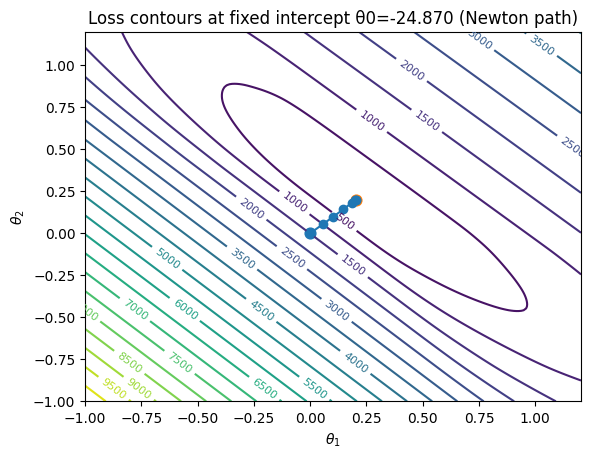

In [297]:
plot_loss_contours_with_path(X, y, history, levels=20, margin=1.0, intercept='final')

In [298]:
theta, history = fit_logreg_newton_irls(X, y, tol=1e-2, backtracking=True)

In [301]:
theta

array([-24.86836578,   0.20336925,   0.19986895])

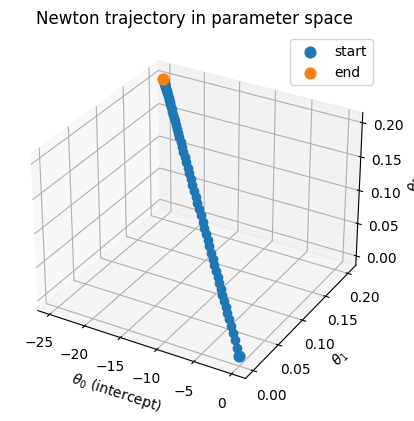

In [307]:
plot_theta_trajectory_3d(history)

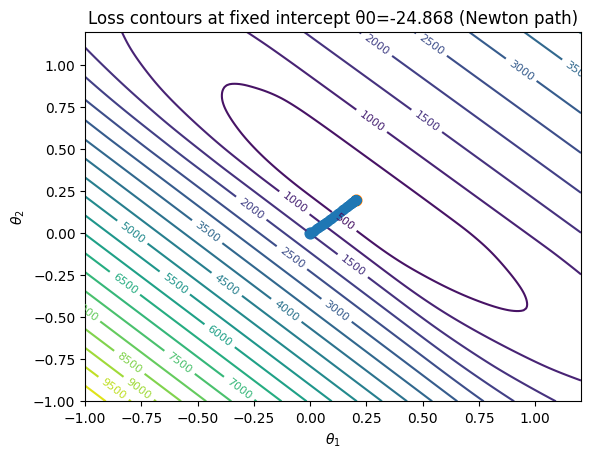

In [309]:
plot_loss_contours_with_path(X, y, history, levels=20, margin=1.0, intercept='final')